<a href="https://colab.research.google.com/github/leadbreak/paper_practice/blob/main/anomaly_detection_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- dataset은 Dacon의 HAICon2021 산업제어시스템 보안위협 탐지 AI 경진대회(https://dacon.io/competitions/official/235757/overview/description)를 사용하였음
- 테스트하는 모델은 anomaly detection에 대표적으로 사용되는 Auto-Encoder, OneClass-SVM, Isolation Tree이며, 결과적으로 각각의 f1-score는 LSTM 기반 AutoEncoder(0.72), OneClassSVM(0.67), IsolationForest(0.17) 순으로 나타났으며, 이들의 예측값을 SMOTE를 통해 데이터 증강을 통해 DATA IMBALANCE를 해소하고, SVM을 통해 STACKING한 결과 F1-SCORE:0.9299/ROC-AUC-SCORE:0.9318로 증가하는 것을 확인
- 이후 전체 데이터 선택, 최대 제거 등을 통해 데이터 변수 중요성을 파악한 뒤 제거했을 때엔 오히려 성능이 하락하는 것을 확인. 추후 다른 feature selection 방식을 시도해볼만함
- 현재 상황에서 auto encoder의 성능이 가장 높게 나타나는 가운데, 이를 CNN-LSTM으로 모델 자체를 향상시키거나 RaPP와 같은 알고리즘을 추가로 적용해볼 수 있을 것으로 기대됨
- 추후 해당 프로세스를 통해 예측한 값을 실제 데이콘 대회에 제출해봄으로써 해당 모델 및 프로세스의 성능을 측정

In [ ]:
# Libraries import

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [ ]:
# generate dataset

from google.colab import drive

drive.mount("/content/gdrive")

!unzip /content/gdrive/MyDrive/HAICon2020_dataset.zip -d /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/MyDrive/HAICon2020_dataset.zip
replace /content/eTaPR-21.8-py3-none-any.whl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from pathlib import Path

TRAIN_DATASET = sorted([x for x in Path("./train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./test/").glob("*.csv")])

TRAIN_DATASET

[PosixPath('train/train1.csv'),
 PosixPath('train/train2.csv'),
 PosixPath('train/train3.csv')]

In [ ]:
def df_from_DS(dataset) :
  df = pd.DataFrame()

  for data in tqdm(dataset) :
    tmp_df = pd.read_csv(data)
    df = df.append(tmp_df, ignore_index=True)

  return df

In [ ]:
train_df = df_from_DS(TRAIN_DATASET)
test_df = df_from_DS(TEST_DATASET)
val_df = pd.read_csv("./validation/validation.csv")

train_df.info() # 921,603개 정상 데이터

100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921603 entries, 0 to 921602
Data columns (total 80 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    921603 non-null  object 
 1   C01     921603 non-null  float64
 2   C02     921603 non-null  int64  
 3   C03     921603 non-null  int64  
 4   C04     921603 non-null  float64
 5   C05     921603 non-null  float64
 6   C06     921603 non-null  float64
 7   C07     921603 non-null  float64
 8   C08     921603 non-null  float64
 9   C09     921603 non-null  float64
 10  C10     921603 non-null  float64
 11  C11     921603 non-null  float64
 12  C12     921603 non-null  float64
 13  C13     921603 non-null  float64
 14  C14     921603 non-null  int64  
 15  C15     921603 non-null  float64
 16  C16     921603 non-null  float64
 17  C17     921603 non-null  float64
 18  C18     921603 non-null  int64  
 19  C19     921603 non-null  int64  
 20  C20     921603 non-null  float64
 21  C21     92

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358804 entries, 0 to 358803
Data columns (total 80 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    358804 non-null  object 
 1   C01     358804 non-null  float64
 2   C02     358804 non-null  float64
 3   C03     358804 non-null  int64  
 4   C04     358804 non-null  float64
 5   C05     358804 non-null  float64
 6   C06     358804 non-null  float64
 7   C07     358804 non-null  float64
 8   C08     358804 non-null  float64
 9   C09     358804 non-null  int64  
 10  C10     358804 non-null  float64
 11  C11     358804 non-null  float64
 12  C12     358804 non-null  float64
 13  C13     358804 non-null  float64
 14  C14     358804 non-null  int64  
 15  C15     358804 non-null  float64
 16  C16     358804 non-null  float64
 17  C17     358804 non-null  float64
 18  C18     358804 non-null  int64  
 19  C19     358804 non-null  int64  
 20  C20     358804 non-null  float64
 21  C21     35

In [ ]:
val_df.info() # 43,201개 labeling된 데이터, 1 = 이상상황

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43201 entries, 0 to 43200
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    43201 non-null  object 
 1   C01     43201 non-null  float64
 2   C02     43201 non-null  float64
 3   C03     43201 non-null  int64  
 4   C04     43201 non-null  float64
 5   C05     43201 non-null  float64
 6   C06     43201 non-null  float64
 7   C07     43201 non-null  float64
 8   C08     43201 non-null  float64
 9   C09     43201 non-null  int64  
 10  C10     43201 non-null  float64
 11  C11     43201 non-null  float64
 12  C12     43201 non-null  float64
 13  C13     43201 non-null  float64
 14  C14     43201 non-null  int64  
 15  C15     43201 non-null  float64
 16  C16     43201 non-null  float64
 17  C17     43201 non-null  float64
 18  C18     43201 non-null  int64  
 19  C19     43201 non-null  int64  
 20  C20     43201 non-null  float64
 21  C21     43201 non-null  int64  
 22

In [ ]:
val_df.attack.value_counts() # labeling된 데이터 상황도 불균형한 상태

0    42572
1      629
Name: attack, dtype: int64

In [ ]:
"""
분별력 없는 변수 = [C3, C8, C14, C18, C19, C21, C22, C25, C33, C34, C35, C37, C40, C43, C51, C52, C59, C64, C67]
분별력 제일 높은 변수 = [C28, C48, C71] # 상호배타적
분별력 높은 변수 = [C9, C31, C36, C41, C54, C56, C60, C73] # min 값이 10배 이상 차이
"""

'\n분별력 없는 변수 = [C3, C8, C14, C18, C19, C21, C22, C25, C33, C34, C35, C37, C40, C43, C51, C52, C59, C64, C67]\n분별력 제일 높은 변수 = [C28, C48, C71] # 상호배타적\n분별력 높은 변수 = [C9, C31, C36, C41, C54, C56, C60, C73] # min 값이 10배 이상 차이\n'

In [ ]:
df = train_df
# data = df.iloc[:, 1:][['C28', 'C48', 'C71']]
data = df.iloc[:, 1:].drop(['C03', 'C08', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C64', "C67"], axis=1)
data

,C28,C48,C71
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0
3,0,0,0.0
4,0,0,0.0
...,...,...,...
921598,0,0,0.0
921599,0,0,0.0
921600,0,0,0.0
921601,0,0,0.0


In [ ]:
# scaling

from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

data

,0,1,2
0,-0.430272,-0.430272,-0.656594
1,-0.430272,-0.430272,-0.656594
2,-0.430272,-0.430272,-0.656594
3,-0.430272,-0.430272,-0.656594
4,-0.430272,-0.430272,-0.656594
...,...,...,...
921598,-0.430272,-0.430272,-0.656594
921599,-0.430272,-0.430272,-0.656594
921600,-0.430272,-0.430272,-0.656594
921601,-0.430272,-0.430272,-0.656594


In [ ]:
# test set also

# X_test = val_df.iloc[:, 1:-1]
X_test = val_df.iloc[:, 1:-1][['C28', 'C48', 'C71']]
X_test = val_df.iloc[:, 1:-1].drop(['C03', 'C08', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C64', "C67"], axis=1)
np_scaled = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(np_scaled)
X_test

,0,1,2
0,-0.430272,-0.430272,-0.656594
1,-0.430272,-0.430272,-0.656594
2,-0.430272,-0.430272,-0.656594
3,-0.430272,-0.430272,-0.656594
4,-0.430272,-0.430272,-0.656594
...,...,...,...
43196,2.324110,2.324110,-0.656594
43197,2.324110,2.324110,-0.656594
43198,2.324110,2.324110,-0.656594
43199,2.324110,2.324110,-0.656594


# 전체 시나리오 
## Scenario 01. 정상데이터(train_df)만을 학습 후 IF와 AE로 예측 후 평가
## Scenario 02. 라벨링 데이터까지 학습 후 IF와 AE로 예측 후 평가

## Scenario 01. 정상데이터(train_df)만으로 학습 후 IF와 AE로 예측 후 평가

In [ ]:
# First Model : Isolation Forest 학습 및 예측

rng = np.random.RandomState(42)
clf = IsolationForest(contamination='auto', bootstrap=True, warm_start=True,  random_state=rng)
clf.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F1BE06EAC00, verbose=0,
                warm_start=True)

In [ ]:
# 라벨링된 val_df 데이터로 평가

Y_valid = clf.predict(X_test)
print("x_valid 정상 비율:", list(Y_valid).count(1)/Y_valid.shape[0])
print("x_valid 비정상 비율:", list(Y_valid).count(-1)/Y_valid.shape[0])
Y_valid

x_valid 정상 비율: 0.5762366611883984
x_valid 비정상 비율: 0.4237633388116016


array([ 1,  1,  1, ..., -1, -1, -1])

In [ ]:
answer_df = pd.DataFrame()
answer_df['answer'] = val_df['attack']
answer_df['predict'] = pd.DataFrame(Y_valid)[0].map(lambda x : 0 if x == 1 else 1)
answer_df

,answer,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43196,0,1
43197,0,1
43198,0,1
43199,0,1


In [ ]:
answer_df[answer_df['answer'] == 1]

,answer,predict
2111,1,0
2112,1,0
2113,1,0
2114,1,0
2115,1,0
...,...,...
21885,1,0
21886,1,0
21887,1,0
21888,1,0


In [ ]:
final_df = pd.DataFrame()
final_df['answer'] = answer_df['answer']

In [ ]:
from sklearn.metrics import f1_score

y_true = answer_df['answer']
y_pred = answer_df['predict']

f1_score(y_true, y_pred)

0.0

In [ ]:
sample_score = clf.score_samples(X_test)
sample_score

array([-0.42975041, -0.42975041, -0.42975041, ..., -0.57768549,
       -0.57768549, -0.57768549])

In [ ]:
sklearn_score_anomalies = clf.decision_function(X_test)
original_paper_score = [-1*s + 0.5 for s in sklearn_score_anomalies]
print(sklearn_score_anomalies)

[ 0.07024959  0.07024959  0.07024959 ... -0.07768549 -0.07768549
 -0.07768549]


In [ ]:
original_paper_score

[0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,
 0.429750412086783,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1be0197050>]],
      dtype=object)

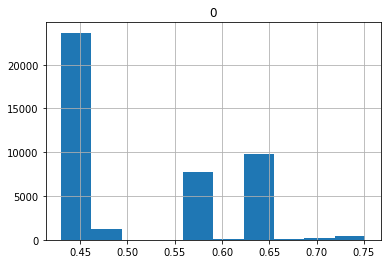

In [ ]:
pd.DataFrame(original_paper_score).hist()

precision:  0.0 , recall:  0.0
threshold:  0.46812898945523135


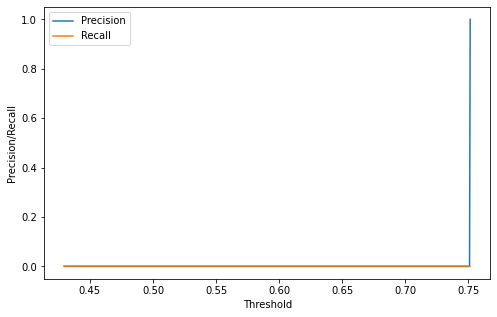

In [ ]:
# find best Threshold by PR curve

error_df = pd.DataFrame({
    'Reconstruction_error':[-1*s for s in sample_score],
    'True_class':answer_df['answer']
})

from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
final_df['pred1'] = [-1*s for s in sample_score]
final_df

,answer,pred1
0,0,0.429750
1,0,0.429750
2,0,0.429750
3,0,0.429750
4,0,0.429750
...,...,...
43196,0,0.577685
43197,0,0.577685
43198,0,0.577685
43199,0,0.577685


In [ ]:
# Second Model : LSTM Auto Encoder

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Build Auto-Encoder's Neural Network with LSTM layers
def autoencoder_model(X) :
  input= Input(shape=(X.shape[1], X.shape[2])) 
  encoder = LSTM(256, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l1(0.1))(input)
  encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
  decoder = RepeatVector(X.shape[1])(encoder)
  decoder = LSTM(64, activation='relu', return_sequences=True)(decoder)
  decoder = LSTM(256, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l1(0.1))(decoder)
  output = TimeDistributed(Dense(X.shape[2]))(decoder)

  model = Model(inputs=input, outputs=output)
  return model

In [ ]:
# change dim of dataset

data_value = data.values
new_data = data_value.reshape(data_value.shape[0], 1, data_value.shape[1])

# build autoencoder model
model = autoencoder_model(new_data)
model.compile(optimizer='adam', loss='mse')
model.summary()

# train & validation
num_epochs = 300
batch_size = 256
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

history = model.fit(new_data, new_data, validation_data=(new_data, new_data), epochs=num_epochs, batch_size=batch_size, callbacks=callbacks)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 256)            266240    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                82176     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 256)            328704    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 3)              771 

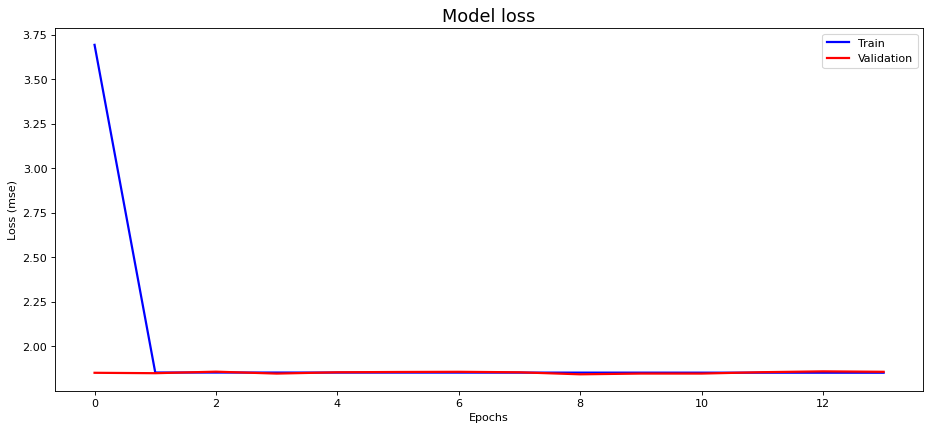

In [ ]:
# visualization the results

fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epochs')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# find best Threshold by PR curve

# reshape test data
data_value = X_test.values
new_data = data_value.reshape(data_value.shape[0], 1, data_value.shape[1])

prediction_3d = model.predict(new_data)
prediction = prediction_3d.reshape(prediction_3d.shape[0], prediction_3d.shape[2])
x_valid = new_data.reshape(new_data.shape[0], new_data.shape[2])

# reconstruction error
mse = np.mean(np.power(x_valid - prediction, 2), axis=1)

error_df = pd.DataFrame({
    'Reconstruction_error':mse,
    'True_class':answer_df['answer']
})

error_df

,Reconstruction_error,True_class
0,0.270226,0
1,0.270226,0
2,0.270226,0
3,0.270226,0
4,0.270226,0
...,...,...
43196,3.747606,0
43197,3.747606,0
43198,3.747606,0
43199,3.747606,0


precision:  0.0 , recall:  0.0
threshold:  0.27192257083569715


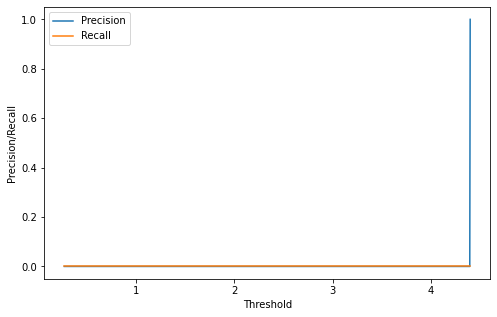

In [ ]:
from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
final_df['pred2'] = error_df['Reconstruction_error']
final_df

,answer,pred1,pred2
0,0,0.429750,0.270226
1,0,0.429750,0.270226
2,0,0.429750,0.270226
3,0,0.429750,0.270226
4,0,0.429750,0.270226
...,...,...,...
43196,0,0.577685,3.747606
43197,0,0.577685,3.747606
43198,0,0.577685,3.747606
43199,0,0.577685,3.747606


In [ ]:
# Third Model : OneClassSVM

from sklearn.svm import OneClassSVM

model = OneClassSVM(nu=float(0.0006519))
model.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.0006519, shrinking=True, tol=0.001,
            verbose=False)

In [ ]:
# 라벨링된 val_df 데이터로 평가

Y_valid = model.predict(X_test)
print("x_valid 정상 비율:", list(Y_valid).count(1)/Y_valid.shape[0])
print("x_valid 비정상 비율:", list(Y_valid).count(-1)/Y_valid.shape[0])
Y_valid

x_valid 정상 비율: 0.971389551167797
x_valid 비정상 비율: 0.02861044883220296


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
answer_df = pd.DataFrame()
answer_df['answer'] = val_df['attack']
answer_df['predict'] = pd.DataFrame(Y_valid)[0].map({1:0, -1:1})
answer_df

,answer,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43196,0,0
43197,0,0
43198,0,0
43199,0,0


In [ ]:
from sklearn.metrics import f1_score

y_true = answer_df['answer']
y_pred = answer_df['predict']

f1_score(y_true, y_pred)

0.0

In [ ]:
sklearn_score_anomalies = model.decision_function(X_test)
original_paper_score = [-1*s + 0.5 for s in sklearn_score_anomalies]
print(sklearn_score_anomalies)

[7.06004784e-06 7.06004784e-06 7.06004784e-06 ... 6.18762073e-07
 6.18762073e-07 6.18762073e-07]


precision:  0.0 , recall:  0.0
threshold:  0.49999938123522725


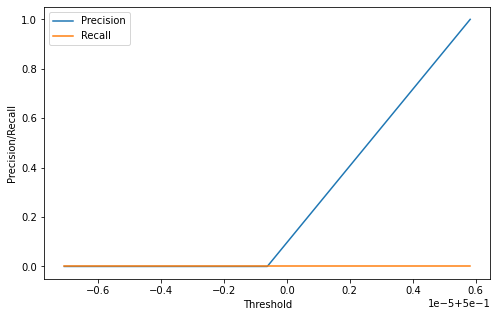

In [ ]:
# find best Threshold by PR curve

error_df = pd.DataFrame({
    'Reconstruction_error':[-1*s + 0.5 for s in sklearn_score_anomalies],
    'True_class':answer_df['answer']
})

from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
# Ensemble

final_df['pred3'] = [-1*s for s in sklearn_score_anomalies]
final_df

,answer,pred1,pred2,pred3
0,0,0.429750,0.270226,-7.060048e-06
1,0,0.429750,0.270226,-7.060048e-06
2,0,0.429750,0.270226,-7.060048e-06
3,0,0.429750,0.270226,-7.060048e-06
4,0,0.429750,0.270226,-7.060048e-06
...,...,...,...,...
43196,0,0.577685,3.747606,-6.187621e-07
43197,0,0.577685,3.747606,-6.187621e-07
43198,0,0.577685,3.747606,-6.187621e-07
43199,0,0.577685,3.747606,-6.187621e-07


In [ ]:
final_df.to_csv("final_df.csv", index=False)

In [ ]:
import pandas as pd

final_df = pd.read_csv("final_df.csv")
final_df

,answer,pred1,pred2,pred3
0,0,0.429750,0.270226,-7.060048e-06
1,0,0.429750,0.270226,-7.060048e-06
2,0,0.429750,0.270226,-7.060048e-06
3,0,0.429750,0.270226,-7.060048e-06
4,0,0.429750,0.270226,-7.060048e-06
...,...,...,...,...
43196,0,0.577685,3.747606,-6.187621e-07
43197,0,0.577685,3.747606,-6.187621e-07
43198,0,0.577685,3.747606,-6.187621e-07
43199,0,0.577685,3.747606,-6.187621e-07


In [ ]:
#scaling

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

df1 = pd.DataFrame(scaler1.fit_transform(final_df.iloc[:, 1:]))
df2 = pd.DataFrame(scaler2.fit_transform(final_df.iloc[:, 1:]))
df = pd.concat([df1, df2], axis=1)
df.columns = [1,2,3,4,5,6]
df = pd.concat([df, answer_df['answer']], axis=1)
df

,1,2,3,4,5,6,answer
0,0.000000,0.034348,0.999999,-0.857184,-0.851107,0.132932,0
1,0.000000,0.034348,0.999999,-0.857184,-0.851107,0.132932,0
2,0.000000,0.034348,0.999999,-0.857184,-0.851107,0.132932,0
3,0.000000,0.034348,0.999999,-0.857184,-0.851107,0.132932,0
4,0.000000,0.034348,0.999999,-0.857184,-0.851107,0.132932,0
...,...,...,...,...,...,...,...
43196,0.459856,0.848113,1.000000,0.746315,0.993678,0.132935,0
43197,0.459856,0.848113,1.000000,0.746315,0.993678,0.132935,0
43198,0.459856,0.848113,1.000000,0.746315,0.993678,0.132935,0
43199,0.459856,0.848113,1.000000,0.746315,0.993678,0.132935,0


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])

print(X.shape, y.shape)
print(pd.DataFrame(y).value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(85144, 6) (85144,)
1    42572
0    42572
dtype: int64


In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

X_test

array([[ 0.        ,  0.03434752,  0.99999937, -0.85718417, -0.85110689,
         0.13293169],
       [ 0.        ,  0.03434752,  0.99999937, -0.85718417, -0.85110689,
         0.13293169],
       [ 0.        ,  0.03434752,  0.99999937, -0.85718417, -0.85110689,
         0.13293169],
       ...,
       [ 0.        ,  0.03434752,  0.99999937, -0.85718417, -0.85110689,
         0.13293169],
       [ 0.45985558,  0.84811271,  0.99999968,  0.74631461,  0.99367797,
         0.13293465],
       [ 0.        ,  0.03434752,  0.99999937, -0.85718417, -0.85110689,
         0.13293169]])

In [ ]:
clf = svm.SVC(C=10000, gamma='auto', kernel='rbf')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
answer = y_test

f1_score(pred, answer)

0.787524510710718

In [ ]:
f1_score(pred, answer)

0.787524510710718

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

roc_auc_score(pred, answer)

0.8247589405590138

In [ ]:
clf = svm.SVC(C=100, gamma='auto', kernel='rbf')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
answer = y_test

f1_score(pred, answer)

0.787524510710718

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(pred, answer)

0.8247589405590138

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel' :['rbf'],
               'C':[100, 1000, 10000],
               'gamma':['auto']}

grid_svc = GridSearchCV(clf, param_grid = parameters, cv=5, verbose=5, n_jobs=5)
grid_svc.fit(X_test, y_test)

result = pd.DataFrame(grid_svc.cv_results_['params'])
result['mean_test_score'] = grid_svc.cv_results_['mean_test_score']
results = result.sort_values(by='mean_test_score', ascending=False)
results

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:   23.5s remaining:   11.7s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:   32.9s finished


,C,gamma,kernel,mean_test_score
0,100,auto,rbf,0.730198
1,1000,auto,rbf,0.730198
2,10000,auto,rbf,0.730198


In [ ]:
outlier_index = df[df.answer == 1].index
outlier_index

Int64Index([ 2111,  2112,  2113,  2114,  2115,  2116,  2117,  2118,  2119,
             2120,
            ...
            21880, 21881, 21882, 21883, 21884, 21885, 21886, 21887, 21888,
            21889],
           dtype='int64', length=629)

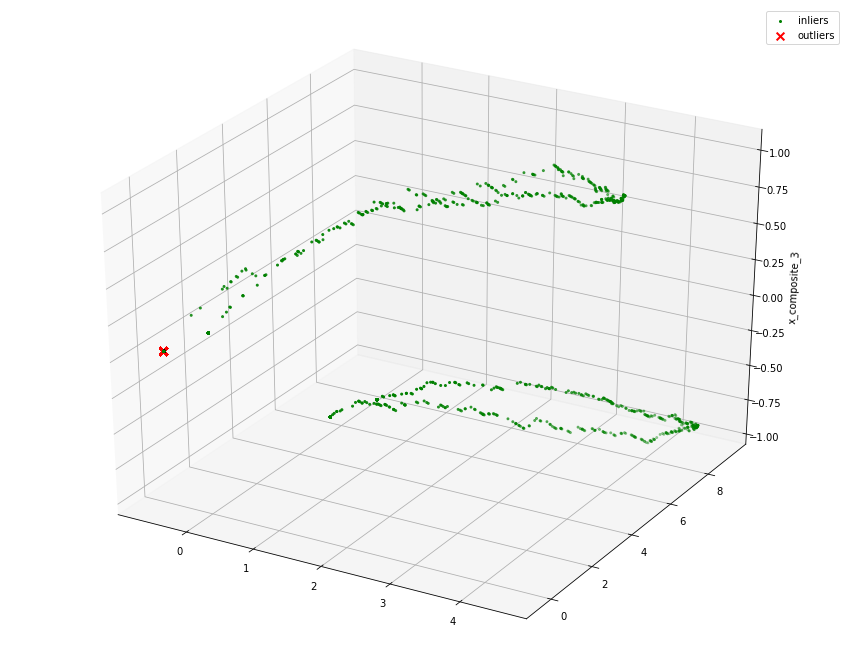

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3) 
scaler = StandardScaler()

#normalize the metrics
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
outlier_index = df[df.answer == 1].index
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

## Scenario 02. 라벨링 데이터까지 학습 후 IF와 AE로 예측 후 평가

In [ ]:
len(val_df[val_df['attack'] == 1] )/len(data)

0.0006519458874548612

In [ ]:
df = train_df.append(val_df.iloc[:,:-1], ignore_index=True)

data = df.iloc[:, 1:].drop(['C03', 'C08', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C64', "C67"], axis=1)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-0.566507,-0.006295,-0.978840,0.088252,-0.660709,-0.800571,1.218800,0.496927,-1.790182,-1.075342,-1.182495,-1.009063,-0.366783,2.046226,-0.766704,-0.955665,0.485214,-1.098577,-1.193811,-0.448957,-0.691887,-0.645240,0.942275,0.081550,0.935040,-0.983497,1.628959,1.043127,0.144395,0.426939,-1.029681,-0.395510,-1.199781,-0.448957,-0.725262,-0.956564,-0.303288,1.039646,-1.070570,0.892596,-0.421679,-1.017317,0.892593,0.0,0.060751,0.0,0.0,-1.206207,0.413293,0.040164,-0.945141,-0.654164,-0.150333,-1.162483,-0.421343,1.614725,-0.791905,-0.810570,2.333074,-0.261468
1,-0.569818,-0.006295,-0.981116,-0.053910,-0.660898,-0.602412,1.248444,0.697204,0.456026,-1.134434,-1.182495,-1.016236,-0.366783,2.068691,-0.817031,-0.964295,0.486822,-1.098577,-1.191253,-0.448957,-0.698682,-0.645240,0.944851,0.081550,0.935040,-0.983497,1.625525,1.043127,0.203522,-0.061320,-0.960400,0.173024,-0.583278,-0.448957,-0.541584,-0.968263,-0.200062,1.039646,-1.066855,0.886353,-0.424732,-1.017966,0.886350,0.0,-0.358657,0.0,0.0,-1.207686,0.413293,0.040164,-0.801741,-0.654164,-0.150333,-1.166129,-0.395246,1.614725,-0.814005,-0.914449,2.333074,-0.673290
2,-0.569818,-0.006295,-0.979977,-0.306040,-0.660898,-0.714160,1.274967,0.668197,-0.864915,-1.111156,-1.182176,-1.001892,-0.366783,2.139455,-0.829477,-0.974075,0.487052,-1.110053,-1.191253,-0.448957,-0.703187,-0.645240,0.941416,-0.030384,0.935040,-0.983497,1.623245,1.043127,0.266995,-0.602528,-0.953473,0.696853,0.855230,-0.448957,-0.725262,-0.977621,-0.160738,1.039646,-1.071194,0.881052,-0.424732,-1.017966,0.881049,0.0,-0.284304,0.0,0.0,-1.211282,0.413293,0.332731,-0.744379,-0.654164,-0.162627,-1.155998,-0.395246,1.614725,-0.825057,-0.881898,2.333074,-0.956372
3,-0.566507,-0.006295,-0.979977,-0.887792,-0.660898,-0.698174,1.301491,0.175715,-1.918015,-1.129360,-1.182495,-1.001892,-0.366783,2.173713,-0.806208,-0.983856,0.487971,-1.092837,-1.193811,-0.448957,-0.773053,-0.645240,0.953438,0.081550,0.935040,-0.983497,1.587759,1.043127,0.298297,-1.276399,-0.891122,1.282659,-0.172275,-0.448957,-0.725262,-0.984641,-0.303288,1.039646,-1.070517,0.882466,-0.424732,-1.018616,0.882463,0.0,0.462114,0.0,0.0,-1.212552,0.413293,0.207345,-0.738645,-0.654164,-0.162627,-1.136574,-0.421343,1.614725,-0.831372,-0.897694,2.333074,-1.100717
4,-0.556566,-0.006295,-0.979977,-1.382651,-0.660898,-0.389356,1.326455,-0.559488,0.109050,-1.141299,-1.182176,-1.016236,-0.366783,2.210780,-0.842465,-0.991909,0.486822,-1.104314,-1.191253,-0.448957,-0.764043,-0.645240,0.956873,0.081550,0.935040,-0.983497,1.592348,1.043127,0.369597,-1.502847,-0.863410,1.082068,-0.377776,-0.448957,-0.357906,-0.991660,-0.200062,1.039646,-1.064293,0.880581,-0.423206,-1.018616,0.880578,0.0,-0.275641,0.0,0.0,-1.214151,0.413293,0.499913,-0.687021,-0.654164,-0.150333,-1.149016,-0.395246,1.614725,-0.844526,-0.938386,2.333074,-0.847625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964799,-0.443924,-0.006295,1.077800,0.258048,-0.659764,0.549779,-0.893735,-1.296184,1.204761,1.767338,1.245804,0.911364,-0.512114,-0.651786,1.694985,1.380703,0.983375,0.909732,1.230111,2.227386,1.660232,-0.757459,0.377878,0.137516,0.446327,0.883602,0.065159,-0.408493,-0.582510,-1.558335,0.889356,-1.914018,0.485328,2.227386,0.560484,1.390165,0.050630,-0.405954,1.177620,0.551180,0.678342,1.334057,0.551179,0.0,-0.544178,0.0,0.0,1.249217,0.406499,-0.670358,0.804338,-0.654164,-0.286049,1.355314,-0.786440,1.540815,1.684390,1.665829,-0.872541,-2.205735
964800,-0.437297,-0.006295,1.077800,1.054609,-0.659764,-0.091695,-0.893735,-0.573565,-1.388421,1.798376,1.246443,0.895587,-0.512114,-0.653471,1.710679,1.384154,0.978090,0.915471,1.232668,2.227386,1.679360,-0

In [ ]:
clf = IsolationForest(contamination=0.01, bootstrap=True, warm_start=True,  random_state=rng)
clf.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7FDEB0E75490, verbose=0,
                warm_start=True)

In [ ]:
# 라벨링된 val_df 데이터로 평가

Y_valid = clf.predict(X_test)
print("x_valid 정상 비율:", list(Y_valid).count(1)/Y_valid.shape[0])
print("x_valid 비정상 비율:", list(Y_valid).count(-1)/Y_valid.shape[0])
Y_valid

x_valid 정상 비율: 0.9999305571630286
x_valid 비정상 비율: 6.94428369713664e-05


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
answer_df = pd.DataFrame()
answer_df['answer'] = val_df['attack']
answer_df['predict'] = pd.DataFrame(Y_valid)[0].map(lambda x : 0 if x == 1 else 1)
answer_df

,answer,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43196,0,0
43197,0,0
43198,0,0
43199,0,0


In [ ]:
y_true = answer_df['answer']
y_pred = answer_df['predict']

f1_score(y_true, y_pred)

0.0

In [ ]:
sklearn_score_anomalies = clf.decision_function(X_test)
original_paper_score = [-1*s + 0.5 for s in sklearn_score_anomalies]
print(sklearn_score_anomalies)

[0.09029875 0.09153265 0.10000753 ... 0.04562826 0.04865738 0.0411906 ]


precision:  0.12559618441971382 , recall:  0.12559618441971382
threshold:  0.4892243372991065


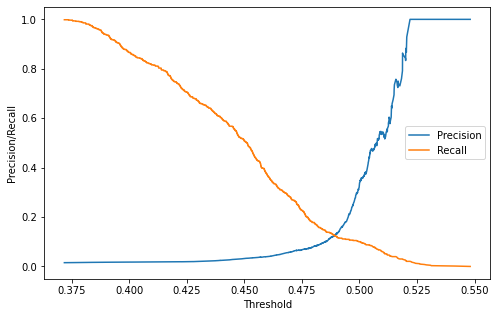

In [ ]:
# find best Threshold by PR curve

error_df = pd.DataFrame({
    'Reconstruction_error':[-1*s + 0.5 for s in sklearn_score_anomalies],
    'True_class':answer_df['answer']
})

from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, accuracy_score

error_df['pred'] = error_df['Reconstruction_error'].map(lambda x : 1 if x > 0.521 else 0)
error_df
precision_score(error_df['True_class'], error_df['pred'])

0.9285714285714286

In [ ]:
accuracy_score(error_df['True_class'], error_df['pred'])

0.9857179231962223

In [ ]:
error_df[error_df['pred'] > 0]

,Reconstruction_error,True_class,pred
14464,0.529060,1,1
14466,0.522508,1,1
14473,0.526256,1,1
14476,0.548113,1,1
14477,0.531158,1,1
14482,0.530912,1,1
14486,0.526157,1,1
14487,0.528190,1,1
14491,0.524292,1,1
14492,0.523447,1,1


In [ ]:
error_df[error_df['True_class'] > 0]

,Reconstruction_error,True_class,pred
2111,0.423177,1,0
2112,0.413938,1,0
2113,0.415004,1,0
2114,0.416733,1,0
2115,0.413820,1,0
...,...,...,...
21885,0.401514,1,0
21886,0.387513,1,0
21887,0.394854,1,0
21888,0.379109,1,0


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 60)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 256)            324608    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                82176     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 256)            328704    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 60)             1542

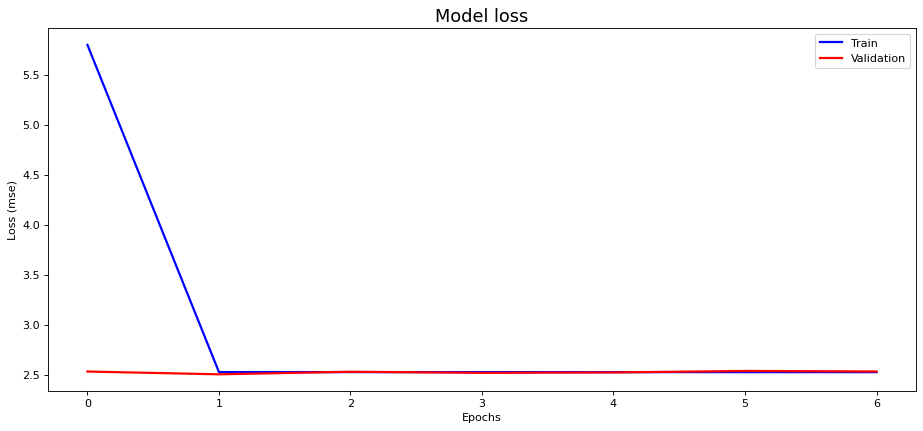

In [ ]:
# LSTM Auto Encoder

# change dim of dataset

data_value = data.values
new_data = data_value.reshape(data_value.shape[0], 1, data_value.shape[1])

# build autoencoder model
model = autoencoder_model(new_data)
model.compile(optimizer='adam', loss='mse')
model.summary()

# train & validation
num_epochs = 300
batch_size = 256
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]

history = model.fit(new_data, new_data, validation_data=(new_data, new_data), epochs=num_epochs, batch_size=batch_size, callbacks=callbacks)

# visualization the results

fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epochs')
ax.legend(loc='upper right')
plt.show()


In [ ]:
# find best Threshold by PR curve

# reshape test data
data_value = X_test.values
new_data = data_value.reshape(data_value.shape[0], 1, data_value.shape[1])

prediction_3d = model.predict(new_data)
prediction = prediction_3d.reshape(prediction_3d.shape[0], prediction_3d.shape[2])
x_valid = new_data.reshape(new_data.shape[0], new_data.shape[2])

# reconstruction error
mse = np.mean(np.power(x_valid - prediction, 2), axis=1)

error_df = pd.DataFrame({
    'Reconstruction_error':mse,
    'True_class':answer_df['answer']
})

error_df

,Reconstruction_error,True_class
0,1.345085,0
1,1.291948,0
2,1.256374,0
3,1.199020,0
4,1.159418,0
...,...,...
43196,1.211108,0
43197,1.199290,0
43198,1.232210,0
43199,1.308186,0


precision:  0.7201907790143084 , recall:  0.7201907790143084
threshold:  2.534668034433293


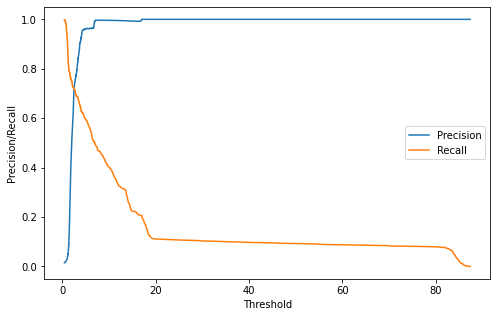

In [ ]:
from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision: ', precision_rt[np.argmin(best_cnt_dic)], ', recall: ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold: ', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
error_df['pred'] = error_df['Reconstruction_error'].map(lambda x : 1 if x > threshold_fixed else 0)
error_df

,Reconstruction_error,True_class,pred
0,1.345085,0,0
1,1.291948,0,0
2,1.256374,0,0
3,1.199020,0,0
4,1.159418,0,0
...,...,...,...
43196,1.211108,0,0
43197,1.199290,0,0
43198,1.232210,0,0
43199,1.308186,0,0


In [ ]:
f1_score(error_df['True_class'], error_df['pred'])

0.7207637231503581